In [526]:

import control
#import pyhull
import string
import picos as pic
import cvxopt as cvx
import math
import numpy as np
import scipy.linalg
import scipy.optimize
import scipy.integrate
import itertools
import sympy
import sympy.physics.mechanics as me
from matplotlib.patches import Ellipse
from pylab import*

Populating the interactive namespace from numpy and matplotlib


/Users/LiYuLin/opt/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['step']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
def R(theta):
    R = np.array([[cos(theta), -sin(theta)], 
                  [sin(theta), cos(theta)]])
    return R

In [3]:
def omega(w_theta, w_l, w_tr):
    omega = np.array([[w_theta],[w_l],[w_tr]])
    return omega

In [566]:
def iekf(t, vt, x0, P0, dt):
    
    theta = x0[0]
    x1 = x0[1]
    x2 = x0[2]
    # left invariant error in exponential coordinate
    X = array([[cos(theta), -sin(theta), x1],
               [sin(theta), cos(theta), x2],
               [0, 0, 1]])
    
    # Initial Condition
    X_h = X
    P = P0
    Xi = array([[pi/180,0,0]]).T
    
    step = int(t/dt)
    
    v = vt[0] # velocity measured by an odometer
    w = vt[1] # velocity measured through differential odometry
    
    Out_X = []
    Out_Xi = []
    Out_Xe = []
    Out_ita = []
    
    for i in range(step):
        
        Q = diag([.1,1e-4,1e-4])
        w_noise = np.random.multivariate_normal(zeros(3), sqrt(Q))
        w_theta = w_noise[0] # differential odometry error
        w_l = w_noise[1] # longitudinal odometry error
        w_tr = w_noise[2] # the transversal shift
        
        A = -array([[0, 0, 0],
                    [0, 0, -w],
                    [-v, w, 0]])
        vt = array([[0, -w, v],
                    [w, 0, 0],
                    [0, 0, 0]])
        wt = array([[0, -w_theta, w_l],
                    [w_theta, 0, w_tr],
                    [0, 0, 0]])
        
        # Reference Trajectory
        dX = X.dot((vt + wt))
        X = X + dX*dt
        Out_X.append(X)
        
        # Propagation
        dXi = A.dot(Xi) - omega(w_theta, w_l, w_tr)
        dX_h = X_h.dot(vt)
        Xi = Xi + dXi*dt
        X_h = X_h + dX_h*dt

        # Covariance Propagation
        dP = A.dot(P)+P.dot(A.T)+Q
        P = P+dP*dt
        
        #iekf Gain
        Vn_cov = 1e-6*eye(2)
        Vn = np.random.multivariate_normal(zeros(2), sqrt(Vn_cov))
        H = array([[0, 1, 0],
                   [0, 0, 1]])
        R = X_h[0:2,0:2]
        N = R.dot(Vn_cov).dot(R.T)
        S = H.dot(P).dot(H.T) + N
        Ln = P.dot(H.T).dot(inv(S)) # Gain
        
        # Measurement
        Y = X.dot(array([[0, 0, 1]]).T) + np.append(Vn,[0]).reshape(3,1)

        # update
        # updated invariant error in exp coordinate
        Xi = Xi - Ln.dot(array([[0,1,0],[0,0,1]]).dot(Xi) - R.dot(Vn.reshape(2,1))) 
        # updated invariant error
        alpha = Xi[0][0]
        u1 = Xi[1][0]
        u2 = Xi[2][0]
        if alpha < pi/18: # less than 10 degree in exp coordinate
            t1 = 1 - alpha**2/6 + alpha**4/120
            t2 = alpha/2 - alpha**3/24 - alpha**5/720
        else:
            t1 = sin(alpha)/alpha
            t2 = 1-cos(alpha)/alpha
        
        Xi_x = array([[t1, -t2],
                      [t2, t1]]).dot(array([[u1],[u2]]))
        R_alpha = np.array([[cos(alpha), -sin(alpha)], 
                            [sin(alpha), cos(alpha)]])
        ita = np.vstack((np.hstack((R_alpha, Xi_x)),array([[0,0,1]])))
        # updated states
        X_h = ita.dot(X)
        
        Out_Xi.append(Xi)
        Out_Xe.append(X_h)
        Out_ita.append(ita)
           
    return Out_Xi, Out_Xe, Out_X, Out_ita

In [567]:
t = 40
vt = [10*pi/t, 2*pi/t]
x0 = [pi,0,5]
P0 = diag([(pi/4)**2,1,1]) # initial covariance?
dt = 0.001
Xi, Xe, X, ita = iekf(t, vt, x0, P0, dt)

In [568]:
xe_x = []
xe_y = []
xr_x = []
xr_y = []
step = int(t/dt)
for i in range(step):
    xe_x.append(Xe[i][0][2])
    xe_y.append(Xe[i][1][2])
    xr_x.append(X[i][0][2])
    xr_y.append(X[i][1][2])

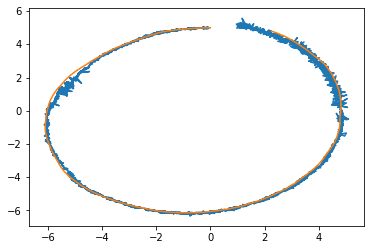

In [569]:
plot(xe_x,xe_y)
plot(xr_x,xr_y)

In [570]:
error = []
for i in range(step):
    error_x = ita[i][0][2]
    error_y = ita[i][1][2]
    error.append(sqrt(error_x**2+error_y**2))

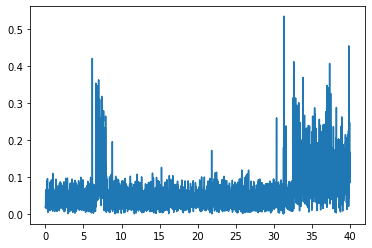

In [571]:
t_x = np.linspace(0, t, step)
plot(t_x ,error)

In [572]:
error_att = []
for i in range(step):
    error_theta = rad2deg(math.asin(-ita[i][0][1]))
    error_att.append(abs(error_theta))

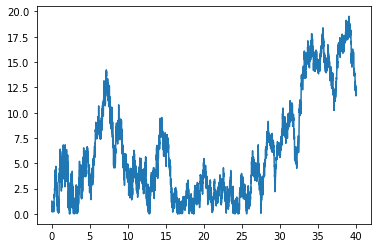

In [573]:
plot(t_x, error_att)

In [516]:
X

[array([[-1.00000000e+00, -9.81285505e-04, -6.45865887e-04],
        [ 9.81285505e-04, -1.00000000e+00,  4.99983077e+00],
        [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]]),
 array([[-1.00000050e+00, -4.72410325e-04, -1.35553492e-03],
        [ 4.72410325e-04, -1.00000050e+00,  4.99962247e+00],
        [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]]),
 array([[-1.00000056e+00, -3.33598445e-04, -2.05578931e-03],
        [ 3.33598445e-04, -1.00000056e+00,  4.99963818e+00],
        [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]]),
 array([[-1.00000103e+00,  1.06557157e-03, -2.78407850e-03],
        [-1.06557157e-03, -1.00000103e+00,  4.99968170e+00],
        [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]]),
 array([[-1.00000048e+00,  1.58774269e-03, -3.62128738e-03],
        [-1.58774269e-03, -1.00000048e+00,  4.99974917e+00],
        [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]]),
 array([[-9.99998598e-01,  2.77022060e-03, -4.32305446e-03],
        [-2.77

In [517]:
ita

[array([[ 0.70630349, -0.70790916, -0.01650559],
        [ 0.70790916,  0.70630349, -0.00708191],
        [ 0.        ,  0.        ,  1.        ]]),
 array([[ 0.7065652 , -0.70764795, -0.03739932],
        [ 0.70764795,  0.7065652 , -0.02592902],
        [ 0.        ,  0.        ,  1.        ]]),
 array([[ 0.70653496, -0.70767814, -0.01962152],
        [ 0.70767814,  0.70653496, -0.00803271],
        [ 0.        ,  0.        ,  1.        ]]),
 array([[ 0.70735692, -0.70685655, -0.02372714],
        [ 0.70685655,  0.70735692,  0.02966913],
        [ 0.        ,  0.        ,  1.        ]]),
 array([[ 0.70766758, -0.70654554, -0.01663727],
        [ 0.70654554,  0.70766758,  0.00315733],
        [ 0.        ,  0.        ,  1.        ]]),
 array([[ 0.70839451, -0.70581671, -0.0280798 ],
        [ 0.70581671,  0.70839451,  0.00132492],
        [ 0.        ,  0.        ,  1.        ]]),
 array([[ 0.70833027, -0.70588118, -0.00321582],
        [ 0.70588118,  0.70833027,  0.02485281],
        

In [136]:
def solve_bounded_disturbance(sys):
    
    A = sys.A
    B = sys.B
    C = sys.C
    D = sys.D
    
    def solve_lmi(A_data, B_data, C_data, D_data, alpha, verbose=False):
        sdp = pic.Problem()

        # shape
        n_x = A_data.shape[0]
        n_u = B_data.shape[1]
        
        # variables
        P = sdp.add_variable('P', (n_x, n_x), vtype='symmetric')
        alpha = pic.new_param('alpha', alpha)
        mu_1 = sdp.add_variable('mu_1')
        mu_2 = sdp.add_variable('mu_2')

        # parameters
        A = pic.new_param('A', cvx.matrix(A_data))
        B = pic.new_param('B', cvx.matrix(B_data))
        C = pic.new_param('C', cvx.matrix(C_data))
        D = pic.new_param('D', cvx.matrix(D_data))
        I_n_u = pic.new_param('I', cvx.sparse(cvx.matrix(np.eye(n_u))))
        I_n_x = pic.new_param('I', cvx.sparse(cvx.matrix(np.eye(n_x))))

        eps = 1e-10
        sdp.add_constraint(
            (P*A + A.T*P + 2*alpha*P & P*B) //
            (B.T*P &  -2*alpha*mu_1*I_n_u)  << -eps)
        sdp.add_constraint(
            (C.T*C - P & C.T*D) //
            (D.T*C & D.T*D - mu_2*I_n_u)  << -eps)
        sdp.add_constraint(P >> eps*I_n_x)
        sdp.add_constraint(mu_1 >> eps)
        sdp.add_constraint(mu_2 >> eps)
        sdp.set_objective('min', mu_1 + mu_2)
        try:
            sdp.solve()
            mu_1 =  sdp.variables['mu_1'].value[0,0]
            mu_2 =  sdp.variables['mu_2'].value[0,0]
            gam = np.sqrt(mu_1 + mu_2)
        except Exception as e:
            print (e)
            gam = -1
            
        return gam, sdp
    
    # we use fmin to solve a line search problem in alpha for minimum gamma
    print('line search')
    alpha_opt  = 1 #scipy.optimize.fmin(lambda alpha: solve_lmi(A, B, C, D, alpha)[0], x0=0.1)
    
    gam, sdp = solve_lmi(A, B, C, D, alpha_opt)
    print (sdp)
    
    if sdp.status == 'optimal':
        P = sdp.variables['P'].value
        mu_1 =  sdp.variables['mu_1'].value[0,0]
        mu_2 =  sdp.variables['mu_2'].value[0,0]
        print ('optimal alpha: ', alpha_opt)
        print ('gamma: ', gam)
        print ('mu_1: ', mu_1)
        print ('mu_2: ', mu_2)
        print ('P: ',  P)
    else:
        sdp = solve_lmi(A, B, C, D, alpha_opt, verbose=True)
        raise RuntimeError('Optimization failed')
        
    return sdp, P, alpha_opt, gam


In [139]:
def lmi_design(A):

    B = -eye(3)
    sys_ie = control.ss(A, B, eye(3), zeros((3,3))) # error system
    
    u_norm = 0.1 # norm of disturbance
    d = 0.5 # size of step in pitch angle

    sdp, P, K= solve_bounded_disturbance(sys_ie)
    e0 = array([[0.02, 0.02, 0.02]]).T # initial error, sets ellipse size
    beta = sqrt(e0.T.dot(P).dot(e0))
    
    return{
        #'sys_b': sys_b,
        #'x_t': x0,
        #'u0': u0,
        'alpha': alpha,
        'beta': beta,
        'gam': gam,
        'P': P
    }

In [140]:
mode = lmi_design(A)

line search
Code 3: Primal solution state claimed empty but optimality is required (primals=True).
-------------------------------------------------------------------
Semidefinite Program
  minimize mu_1 + mu_2
  over
    1×1 real variable mu_1, mu_2
    3×3 symmetric variable P
  subject to
    [P·A + Aᵀ·P + 2·alpha·P, P·B; Bᵀ·P, -2·alpha·mu_1·I] ≼ [-1e-10]
    [Cᵀ·C - P, Cᵀ·D; Dᵀ·C, Dᵀ·D - mu_2·I] ≼ [-1e-10]
    P ≽ 1e-10·I
    mu_1 ≽ 1e-10
    mu_2 ≽ 1e-10
-------------------------------------------------------------------
Code 3: Primal solution state claimed empty but optimality is required (primals=True).


/Users/LiYuLin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: Problem.add_variable is deprecated: Variables can now be created independent of problems, and do not need to be added to any problem explicitly.
  app.launch_new_instance()
/Users/LiYuLin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: new_param is deprecated: Use Constant instead.
/Users/LiYuLin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: Problem.add_variable is deprecated: Variables can now be created independent of problems, and do not need to be added to any problem explicitly.
/Users/LiYuLin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: Problem.add_variable is deprecated: Variables can now be created independent of problems, and do not need to be added to any problem explicitly.
/Users/LiYuLin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py

RuntimeError: Optimization failed